# 📌 1. Загрузка и начальная проверка данных

In [4]:
import numpy as np
import pandas_ta as ta
import requests
import pandas as pd
import json
from pybit.unified_trading import HTTP
from datetime import datetime
import time
import math
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
# Исправленные импорты:
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score, roc_auc_score, precision_recall_curve, precision_recall_curve, roc_curve, auc, classification_report
import xgboost as xgb
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier, plot_importance
from joblib import dump, load
from scipy.signal import argrelextrema
import shap
from scipy.stats import wasserstein_distance  # Альтернатива, если нет POT
import ot
from tqdm import tqdm
import joblib
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from joblib import Parallel, delayed
from sklearn.model_selection import cross_val_score
import importlib
import modules.indicators
importlib.reload(modules.indicators);
import sys
from modules.create_df import kline_candles, load_kline_data_from_csv
#добавление только 2 шт, т.к. они ссылаются на добавление таргетов и apply_indicators, который ссылается на сами индюки
from modules.all_kline_changes import keep_selected_features, drop_low_importance_features, apply_main_indicators, apply_indicators, add_target_column_mod, apply_add_indicators, add_target_column_mod_sma_stochrsi_volume_surge
from modules.Save_and_Load import load_model_with_threshold, save_model_with_threshold
from modules.graphs_and_tables import evaluate_model_with_threshold, plot_feature_pairplot,\
    plot_correlation_matrix, explain_model_shap, explain_model_permutation, show_rfecv_results,\
    explain_model_boruta, explain_model_mutual_info, explain_model_granger, plot_f1_vs_n_estimators,\
    show_class_balance, get_top_correlated_pairs

## Загрузка данных с Bybit и формирование df и целевой переменной

**Функция kline_candles состоит из основных блоков:**
1) Загружает график с биржи в формате Data, Volume, High, Low, Open, Close. На вход подаются название **торговой пары**, **таймфрейм**
2) Формирует целевой признак y = 1: рост цены на **target%** за **target_candles** с соотношением риск / прибыль **rr_threshold**
 

In [111]:
# Запуск
if __name__ == '__main__':
    start_time = time.time()

    try:
        df = kline_candles(symbol='LINKUSDT', tf=1, start='2022-03-10 00:00', end='2024-12-09 21:00',
                            target_candles=30, target=0.01, rr_threshold=2.0)
        df_test = kline_candles(symbol='LINKUSDT', tf=1, start='2024-12-11 00:00', end='2025-07-11 00:00', 
                           target_candles=30, target=0.01, rr_threshold=2.0)
        print("Данные успешно загружены и обработаны")
    except NameError as e:
        # Получаем информацию о месте ошибки
        tb = e.__traceback__
        line_number = tb.tb_lineno if tb else "неизвестно"
        print(f"Ошибка имени (вероятно отсутствует импорт): {e}, возникает в строке: {line_number}")
    except Exception as e:
        print(f"Другая ошибка при обработке: {e}")
    print("Время выполнения: {:.2f} сек".format(time.time() - start_time))

Данные успешно загружены и обработаны
Время выполнения: 86.25 сек


## Загрузка / Сохранение 

### Сохранение df на пк

**Сохранение df с сырыми данными**

In [7]:
df.to_csv("LINKUSDT_m1_train_raw_data.csv", index=False)
df_test.to_csv("LINKUSDT_m1_test_raw_data.csv", index=False)

**Сохранение df с признаками**

In [96]:
df.to_csv("LINK_train_m1_base_features.csv", index=False, compression='zstd')
df_test.to_csv("LINK_test_m1_base_features.csv", index=False, compression='zstd')

### Загрузка df

**Загрузка df с сырыми данными**

In [5]:
df= pd.read_csv('LINKUSDT_m1_train_raw_data.csv')
df_test = pd.read_csv('LINKUSDT_m1_test_raw_data.csv')
df.head(3)

Data    Open    High     Low   Close  Volume  target
0  2022-03-09 21:01:00  13.838  13.838  13.817  13.823  1386.0       0
1  2022-03-09 21:02:00  13.823  13.855  13.823  13.855   853.7       0
2  2022-03-09 21:03:00  13.855  13.855  13.849  13.855   154.0       0

**Загрузка df с признаками**

In [104]:
df= pd.read_csv('LINK_train_m1_base_features.csv', compression='zstd')
df_test = pd.read_csv('LINK_test_m1_base_features.csv', compression='zstd')
df.head(3)

atr_24_norm  KeltnerWidth_v3  ema200_norm  ema50_norm  ema20_ema50_diff  \
0     0.096074         0.104418     0.506825    0.510761          0.001403   
1     0.090431         0.103776     0.506896    0.510888          0.001450   
2     0.087281         0.103551     0.506965    0.511005          0.001480   

   ema50_diff_mean5  ema200_diff_mean5  vwap_intraday_norm  vwap_ema6h_norm  \
0         -0.002698          -0.006634            0.510034         0.509097   
1         -0.002834          -0.006826            0.510074         0.509175   
2         -0.002839          -0.006878            0.510080         0.509248   

                  Data    High     Low   Close    Open  Volume  target  
0  2022-03-10 00:20:00  14.090  14.076  14.087  14.090    21.7       0  
1  2022-03-10 00:21:00  14.094  14.087  14.092  14.087   277.6       0  
2  2022-03-10 00:22:00  14.095  14.081  14.089  14.092    36.6       0

## Формирование цели

**Формирование цели.** Рост цены на **target%** за **target_candles** с соотношением риск / прибыль **rr_threshold**

In [6]:
df = df.drop('target',axis=1)
df = add_target_column_mod(df, target_candles=30, target=0.01, rr_threshold=2.0)
df_test = df_test.drop('target',axis=1)
df_test = add_target_column_mod(df_test, target_candles=30, target=0.01, rr_threshold=2.0)

Формирование цели с условием

In [3]:
df = df.drop('target',axis=1)
df = add_target_column_mod_sma_stochrsi_volume_surge(df, target_candles=30, target=0.005, rr_threshold=2.0)
df_test = df_test.drop('target',axis=1)
df_test = add_target_column_mod_sma_stochrsi_volume_surge(df_test, target_candles=30, target=0.005, rr_threshold=2.0)

## Загрузка индикаторов и чистка данных

Функция **apply_main_indicators** формирует новые признаки - индикаторы для трейдинга. На вход подается **Lookback** на основании которого идет расчет краткосрочных индикаторов

In [33]:
df = apply_main_indicators(df, length = 20)
df_test = apply_main_indicators(df_test, length = 20)
df.head(3)

Data    Open    High     Low   Close  Volume  target  RSI21  \
0  2022-03-09 21:01:00  13.838  13.838  13.817  13.823  1386.0       0    NaN   
1  2022-03-09 21:02:00  13.823  13.855  13.823  13.855   853.7       0    NaN   
2  2022-03-09 21:03:00  13.855  13.855  13.849  13.855   154.0       0    NaN   

   RSI21_diff  RSI_50_21_diff  ...  ema100_slope  ema200_slope  \
0         NaN             NaN  ...           NaN           NaN   
1         NaN             NaN  ...           NaN           NaN   
2         NaN             NaN  ...           NaN           NaN   

   ema20_ema50_diff  ema50_ema100_diff  ema100_ema200_diff  ema20_diff  \
0               NaN                NaN                 NaN         NaN   
1               NaN                NaN                 NaN         NaN   
2               NaN                NaN                 NaN         NaN   

   ema50_diff  ema100_diff  ema200_diff  fib_dist_050_last50  
0         NaN          NaN          NaN                 -1.0  
1         NaN          NaN          NaN                 -1.0  
2         NaN          NaN          NaN                 -1.0  

[3 rows x 34 columns]

### Оставить базовый набор индикаторов 

Базовый набор индикаторов + первичные признаки 'Data', 'High', 'Low', 'Close', 'Open', 'Volume', 'target'

In [45]:
base_features = ['ema20_norm', 
                 'ema200_norm',
                'RSI21',
                'fib_dist_050_last50',
                 'ema100_norm',
                 'RSI_50_21_diff',
                 'ema50_ema100_diff',
                 'ema200_slope',
                 'ema100_slope',
                 'ema100_ema200_diff',
                'Data', 'High', 'Low', 'Close', 'Open', 'Volume','target']

#### Описание базовых индикаторов

**RSI**\
df['RSI21'] = ta.rsi(df['Close'], length=21) / 100\
df['RSI_50_21_diff'] = (ta.rsi(df['Close'], length=50) / 100) - df['RSI21']

**EMA**\
 Нормализация EMA:\
 price_norm = price / price.rolling(60).mean()\
 emaX = ta.ema(price_norm, X)



In [49]:
df = df[base_features]
df_test = df_test[base_features]
df.head(3)

ema20_norm  ema200_norm  RSI21  fib_dist_050_last50  ema100_norm  \
0         NaN          NaN    NaN                 -1.0          NaN   
1         NaN          NaN    NaN                 -1.0          NaN   
2         NaN          NaN    NaN                 -1.0          NaN   

   RSI_50_21_diff  ema50_ema100_diff  ema200_slope  ema100_slope  \
0             NaN                NaN           NaN           NaN   
1             NaN                NaN           NaN           NaN   
2             NaN                NaN           NaN           NaN   

   ema100_ema200_diff                 Data    High     Low   Close    Open  \
0                 NaN  2022-03-09 21:01:00  13.838  13.817  13.823  13.838   
1                 NaN  2022-03-09 21:02:00  13.855  13.823  13.855  13.823   
2                 NaN  2022-03-09 21:03:00  13.855  13.849  13.855  13.855   

   Volume  target  
0  1386.0       0  
1   853.7       0  
2   154.0       0

### Добавление новых индиаторов

После формирования основных индикаторов можно эксперементировать с добавлением новых через **apply_add_indicators**

In [13]:
df = apply_add_indicators(df, length = 20)
df_test = apply_add_indicators(df_test, length = 20)


Начальное количество NaN в df: 1291
⏱️ resistance_slope_dist_200: 1.91 сек
Итоговое количество NaN в df: 0
Начальное количество NaN в df: 1291
⏱️ resistance_slope_dist_200: 0.41 сек
Итоговое количество NaN в df: 0


### Удаление дубликатов, Nan, inf и информация о df

In [51]:
df = df.loc[:, ~df.columns.duplicated(keep='first')]
df.dropna(inplace=True)
df_test = df_test.loc[:, ~df_test.columns.duplicated(keep='first')]
df_test.dropna(inplace=True)

In [52]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1448377 entries, 263 to 1448639
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   ema20_norm           1448377 non-null  float64
 1   ema200_norm          1448377 non-null  float64
 2   RSI21                1448377 non-null  float64
 3   fib_dist_050_last50  1448377 non-null  float32
 4   ema100_norm          1448377 non-null  float64
 5   RSI_50_21_diff       1448377 non-null  float64
 6   ema50_ema100_diff    1448377 non-null  float64
 7   ema200_slope         1448377 non-null  float64
 8   ema100_slope         1448377 non-null  float64
 9   ema100_ema200_diff   1448377 non-null  float64
 10  Data                 1448377 non-null  object 
 11  High                 1448377 non-null  float64
 12  Low                  1448377 non-null  float64
 13  Close                1448377 non-null  float64
 14  Open                 1448377 non-null  float64
 15  V

((1448377, 17), None)

In [53]:
df.describe().round(3)

ema20_norm  ema200_norm        RSI21  fib_dist_050_last50  \
count  1448377.000  1448377.000  1448377.000          1448377.000   
mean         1.000        1.000        0.502               -0.958   
std          0.005        0.002        0.094                0.209   
min          0.908        0.968        0.029               -1.000   
25%          0.998        0.999        0.438               -1.000   
50%          1.000        1.000        0.501               -1.000   
75%          1.002        1.001        0.565               -1.000   
max          1.063        1.024        0.922                1.000   

       ema100_norm  RSI_50_21_diff  ema50_ema100_diff  ema200_slope  \
count  1448377.000     1448377.000        1448377.000   1448377.000   
mean         1.000          -0.000             -0.000        -0.000   
std          0.003           0.047              0.001         0.000   
min          0.953          -0.223             -0.022        -0.002   
25%          0.999          -0.033             -0.001        -0.000   
50%          1.000          -0.000             -0.000        -0.000   
75%          1.001           0.033              0.001         0.000   
max          1.038           0.189              0.020         0.001   

       ema100_slope  ema100_ema200_diff         High          Low  \
count   1448377.000         1448377.000  1448377.000  1448377.000   
mean         -0.000              -0.000       10.579       10.565   
std           0.000               0.001        4.416        4.408   
min          -0.005              -0.017        4.805        4.667   
25%          -0.000              -0.001        6.923        6.916   
50%          -0.000              -0.000        8.118        8.105   
75%           0.000               0.001       14.150       14.132   
max           0.003               0.016       27.428       27.374   

             Close         Open       Volume       target  
count  1448377.000  1448377.000  1448377.000  1448377.000  
mean        10.572       10.572     4796.299        0.084  
std          4.412        4.412    14361.472        0.277  
min          4.679        4.679        0.000        0.000  
25%          6.919        6.919      518.300        0.000  
50%          8.111        8.111     1594.500        0.000  
75%         14.141       14.141     4366.300        0.000  
max         27.417       27.417  1424228.600        1.000

In [54]:
pd.set_option('display.max_columns', 200)
df.tail(3)

ema20_norm  ema200_norm     RSI21  fib_dist_050_last50  ema100_norm  \
1448637    0.973309     0.989748  0.364483            -0.405271     0.985128   
1448638    0.972833     0.989535  0.360772            -0.418981     0.984795   
1448639    0.972533     0.989337  0.364704            -0.409587     0.984496   

         RSI_50_21_diff  ema50_ema100_diff  ema200_slope  ema100_slope  \
1448637        0.005034          -0.006011     -0.000295     -0.000451   
1448638        0.006594          -0.006102     -0.000307     -0.000473   
1448639        0.004830          -0.006156     -0.000312     -0.000478   

         ema100_ema200_diff                 Data    High     Low   Close  \
1448637           -0.004620  2024-12-09 20:58:00  22.509  22.358  22.386   
1448638           -0.004740  2024-12-09 20:59:00  22.486  22.360  22.367   
1448639           -0.004841  2024-12-09 21:00:00  22.416  22.285  22.378   

           Open   Volume  target  
1448637  22.451  64890.1       0  
1448638  22.386  29393.1       0  
1448639  22.367  61537.7       0

In [19]:
# Проверяем, есть ли бесконечности в данных
inf_check = df.isin([np.inf, -np.inf]).any()
print("Столбцы с inf:\n", inf_check)

# Считаем количество строк с inf в любом столбце
rows_with_inf = df.isin([np.inf, -np.inf]).any(axis=1).sum()
print(f"Всего строк с inf: {rows_with_inf}")

Столбцы с inf:
 Data                           False
Open                           False
High                           False
Low                            False
Close                          False
Volume                         False
target                         False
RSI21                          False
RSI21_diff                     False
RSI_50_21_diff                 False
price_above_ema20              False
price_above_ema50              False
price_above_ema100             False
price_above_ema200             False
ema9_crossed_ema20_last5       False
ema20_crossed_ema50_last5      False
ema50_crossed_ema100_last5     False
ema100_crossed_ema200_last5    False
ema20_norm                     False
ema50_norm                     False
ema100_norm                    False
ema200_norm                    False
ema20_slope                    False
ema50_slope                    False
ema100_slope                   False
ema200_slope                   False
ema20_ema50_diff      

In [446]:
# Удаляем строки, где есть хотя бы одно inf
df = df[~df.isin([np.inf, -np.inf]).any(axis=1)]

# Проверяем, что inf больше нет
print("Остались ли inf после удаления:", df.isin([np.inf, -np.inf]).any().any())

Остались ли inf после удаления: False


# ✂️ 2. Разбиение выборки

## Разбиение выборки на train и valid

In [59]:
#Разбиваем выборку с учетом временных рядов:

X = df.drop(['target','Data','High','Low','Close','Open', 'Volume'],axis=1)
y = df['target']
separate = int(len(X) * 0.8)
X_train = X.iloc[:separate]
X_valid = X.iloc[separate:]
y_train = y.iloc[:separate]
y_valid = y.iloc[separate:]
feature_columns = X.columns.tolist()

print(f'размер датасета = {df.shape}')
print(f'размер обучающей выборки Х = {X_train.shape}, y = {y_train.shape}')
print(f'размер валидационной выборки Х = {X_valid.shape}, y = {y_valid.shape}')

размер датасета = (1448377, 17)
размер обучающей выборки Х = (1158701, 10), y = (1158701,)
размер валидационной выборки Х = (289676, 10), y = (289676,)


Разбиение тестовой выборки **X_test**, **y-test**

In [62]:
X_test = df_test.drop(['target','Data','High','Low','Close','Open', 'Volume'],axis=1)
y_test = df_test['target']


print(f'размер датасета = {X_test.shape}')

размер датасета = (305017, 10)


## Проверка временных диапазонов

Проверка временных диапазонов. Даты обучающей и тестовой выборок не должны пересекаться.

In [66]:
print(f"Диапазон дат обучающей выборки {df['Data'].agg(['min', 'max'])}")
print(f"Диапазон дат отложенной (тестовой) выборки {df_test['Data'].agg(['min', 'max'])}")

Диапазон дат обучающей выборки min    2022-03-10 01:24:00
max    2024-12-09 21:00:00
Name: Data, dtype: object
Диапазон дат отложенной (тестовой) выборки min    2024-12-12 01:24:00
max    2025-07-11 21:00:00
Name: Data, dtype: object


# 📊 3. Распределение целевой переменной (target)

**Цель**: определение дисбаланса классов

#### Распределение целевой переменной на всем df

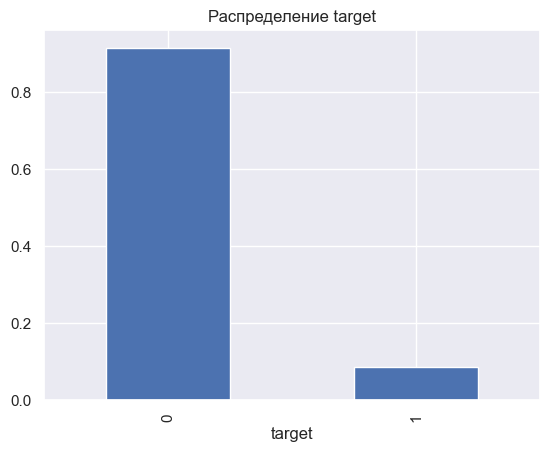

In [35]:
df['target'].value_counts(normalize=True).plot(kind='bar', title='Распределение target');

#### Распределение целевой переменной внутри выборок

Функция **show_class_balance** принимает Series с целевой переменой: **y**, **y_train**, **y_valid**, **y_test** и считает баланс классов

📊 Баланс классов (доли):
  target    Весь датасет    Обучающая    Валидационная    Тестовая
--------  --------------  -----------  ---------------  ----------
       0           0.916        0.916            0.917       0.880
       1           0.084        0.084            0.083       0.120


<Figure size 1000x500 with 0 Axes>

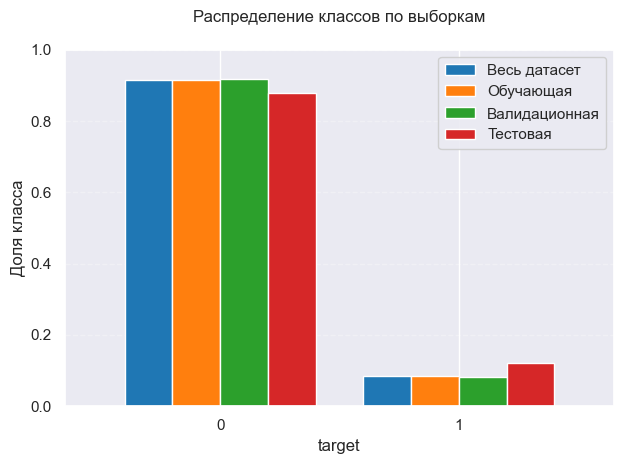

In [39]:
show_class_balance(y, y_train, y_valid, y_test);

# 📈 4. Временной анализ

## Временной анализ целевой переменной

**Цель**: проверить поведение target и цены во времени

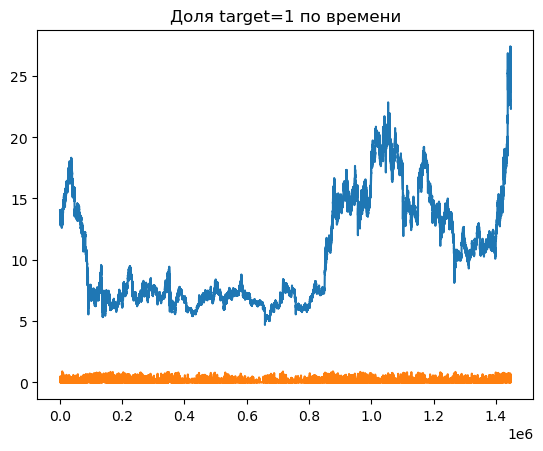

In [25]:
df['Close'].plot(title='Цена LINKUSDT')
df['target'].rolling(100).mean().plot(title='Доля target=1 по времени');

## Распределение признаков по времени

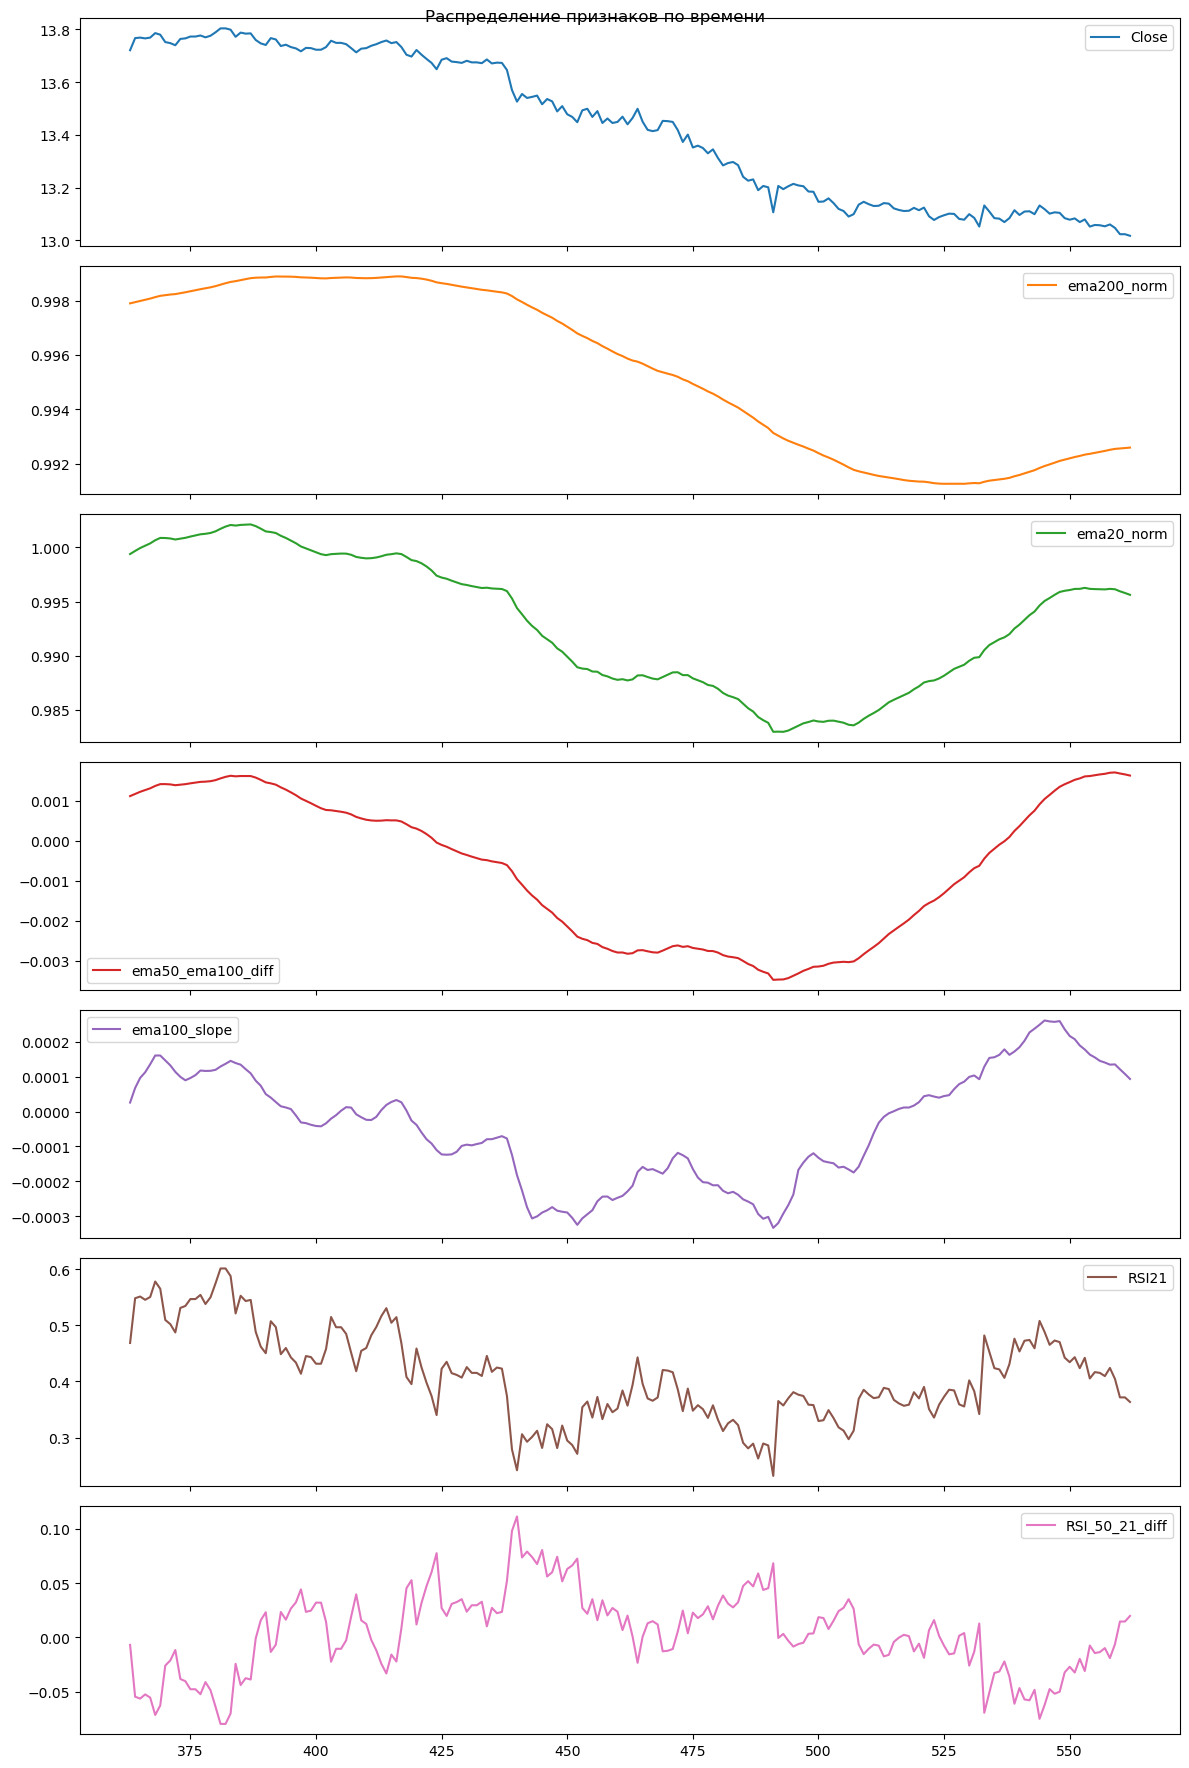

In [74]:
features = ['Close','ema200_norm', 'ema20_norm','ema50_ema100_diff', 'ema100_slope','RSI21',
            'RSI_50_21_diff']

# Создаем отдельные графики для каждого признака
df[features].iloc[100:300].plot(subplots=True, figsize=(12, 18), layout=(len(features), 1),
                 title='Распределение признаков по времени', sharex=True)
plt.tight_layout()

## Сравнение среднеквадратичных отклонений

Сравнение среднеквадратичных отклонений для базовой и нормализованной EMA

In [119]:
window = 60  # период для std

# Относительное std для ema50
ema200 = ta.ema(df['Close'], 200)
df['ema200_std'] = ema200.rolling(window).std() / ema200.rolling(window).mean()

# Относительное std для ema50_norm
df['ema200_norm_std'] = df['ema200_norm'].rolling(window).std() / df['ema200_norm'].rolling(window).mean()

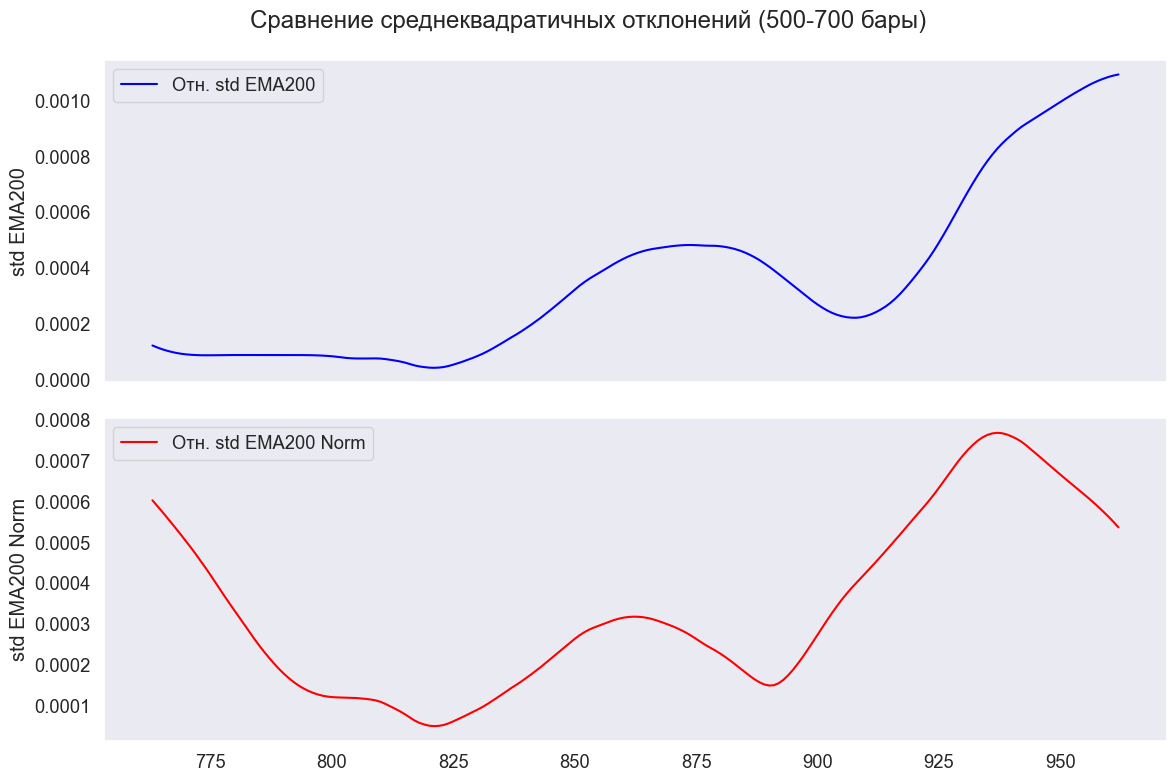

In [120]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# График 1: Относительный std для ema200
ax1.plot(df['ema200_std'].iloc[500:700], label='Отн. std EMA200', color='blue')
ax1.set_ylabel('std EMA200')
ax1.legend()
ax1.grid()

# График 2: Относительный std для ema200_norm
ax2.plot(df['ema200_norm_std'].iloc[500:700], label='Отн. std EMA200 Norm', color='red')
ax2.set_ylabel('std EMA200 Norm')
ax2.legend()
ax2.grid()

# Общий заголовок и настройки
plt.suptitle("Сравнение среднеквадратичных отклонений (500-700 бары)")
plt.tight_layout()
plt.show()
df.drop(['ema200_std'],axis=1,inplace=True)

# ⚙️ 5. Статистика по индикаторам

## Сравнение цены и индикаторов

**Цель**: понять распределение и выбросы

In [84]:
df['ema100'] = ta.ema(df['Close'], 100)
df['ema20'] = ta.ema(df['Close'], 20)

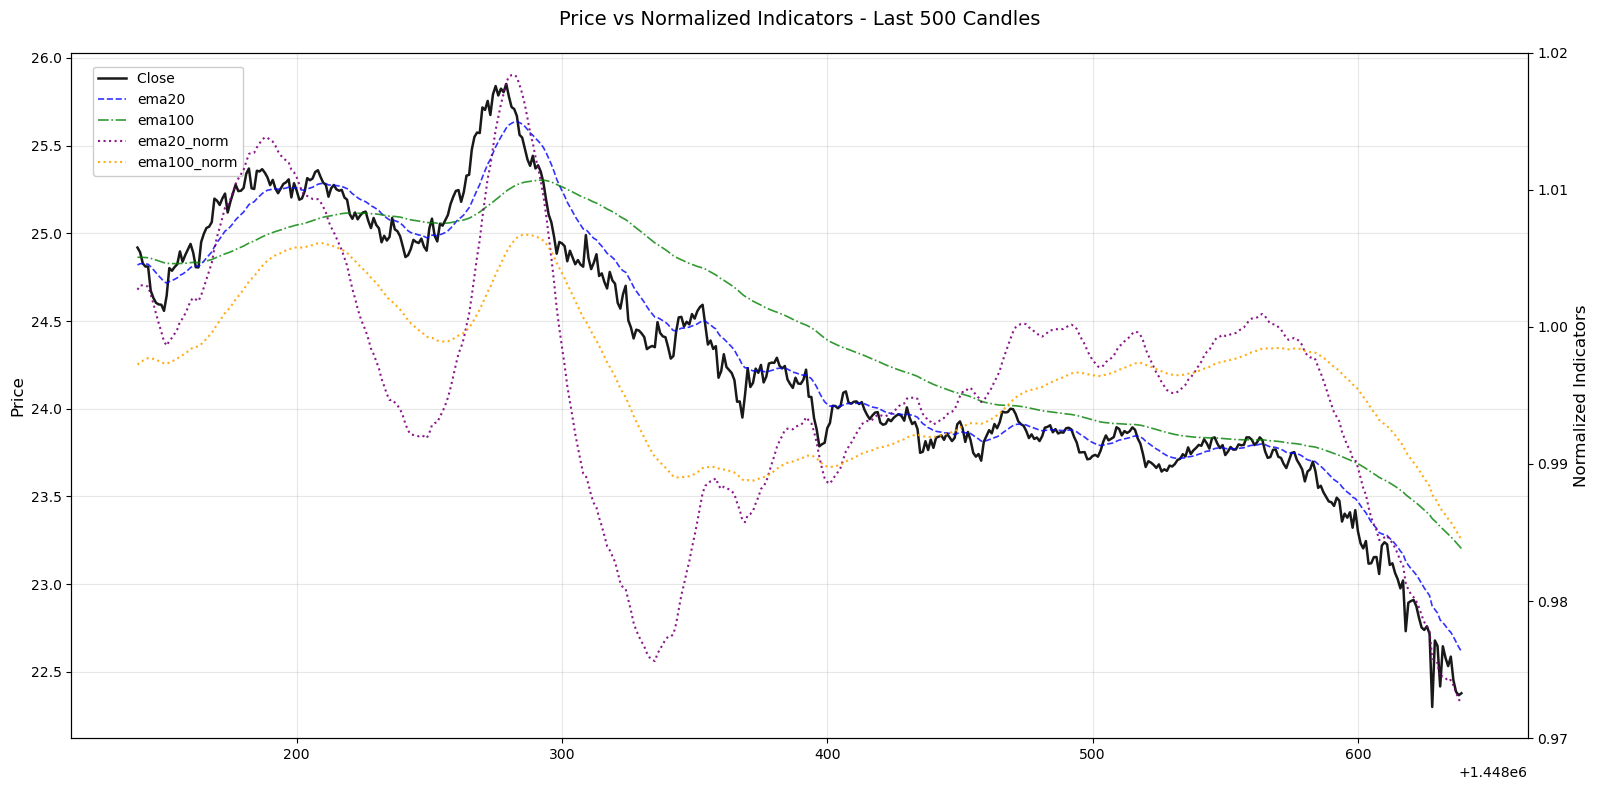

In [86]:
# Выбираем последние 500 свечей для анализа
plot_data = df.iloc[-500:].copy()

# Создаем фигуру с двумя осями Y
plt.figure(figsize=(16, 8))

# Первая ось (цена)
ax1 = plt.gca()
ax1.plot(plot_data['Close'], 
         label='Close ', 
         color='black', 
         linewidth=1.8,
         alpha=0.9)
ax1.set_ylabel('Price', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# Вторая ось (нормализованные признаки)
ax2 = ax1.twinx()

# Графики нормализованных признаков с разными цветами и стилями

ax1.plot(plot_data['ema20'], 
         label='ema20', 
         color='blue',
         linestyle='--',
         linewidth=1.2,
         alpha=0.8)

ax1.plot(plot_data['ema100'], 
         label='ema100', 
         color='green',
         linestyle='-.',
         linewidth=1.2,
         alpha=0.8)

ax2.plot(plot_data['ema20_norm'], 
         label='ema20_norm', 
         color='purple',
         linestyle=':',
         linewidth=1.5,
         alpha=0.9)

ax2.plot(plot_data['ema100_norm'], 
         label='ema100_norm', 
         color='orange',
         linestyle=':',
         linewidth=1.5,
         alpha=0.9)

ax2.set_ylabel('Normalized Indicators', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

# Добавляем легенды
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Объединяем легенды и размещаем их в одном месте
ax1.legend(lines1 + lines2, labels1 + labels2, 
           loc='upper left',
           bbox_to_anchor=(0.01, 0.99),
           framealpha=1,
           fontsize=10)

# Добавляем горизонтальную линию на уровне 0 для нормированных показателей
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)

plt.title('Price vs Normalized Indicators - Last 500 Candles', fontsize=14, pad=20)
plt.tight_layout()
ax2.set_ylim(0.97, 1.02)  # Фиксируем диапазон для нормализованных показателей
plt.show()
df.drop(['ema100','ema20'],axis=1,inplace=True)

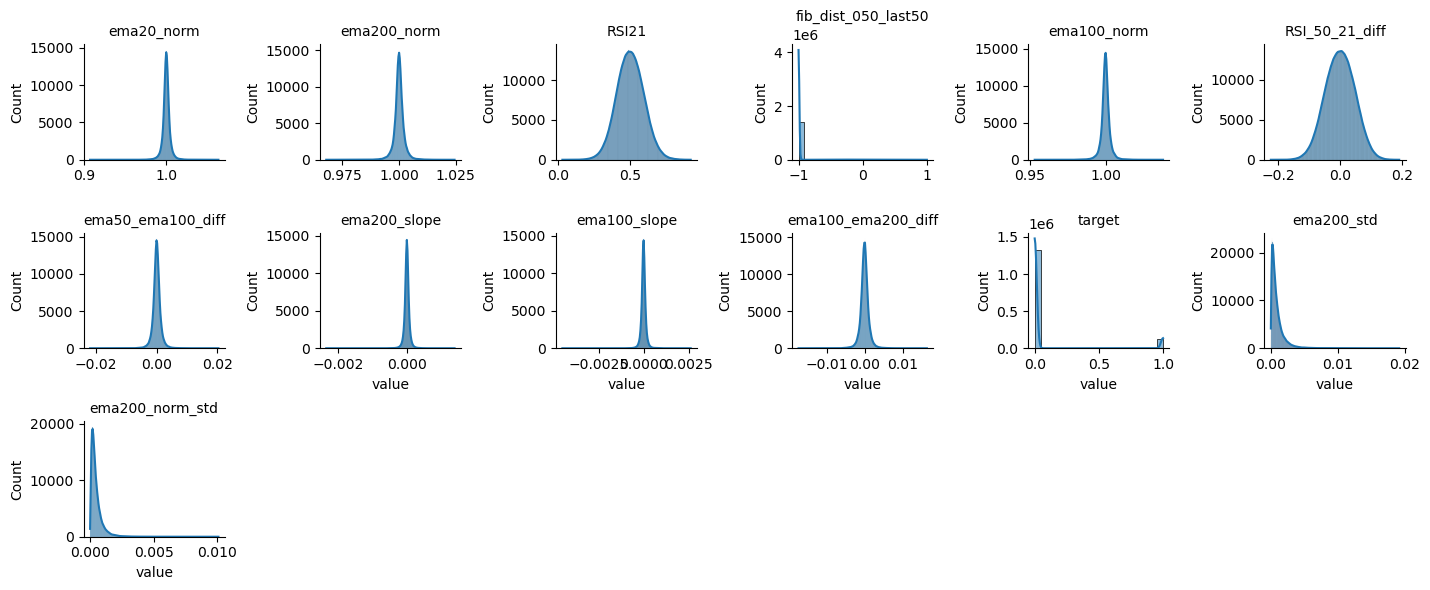

In [90]:
# Подготовка данных для FacetGrid
num_features = df.drop(['Data', 'High', 'Low', 'Close', 'Open', 'Volume'],axis=1).columns
# Выбор признаков для описания num_features
plot_data = pd.melt(df[num_features])

# Создаем сетку графиков
g = sns.FacetGrid(plot_data, col="variable", col_wrap=6, sharex=False, sharey=False, height=2, aspect=1.2)
g.map(sns.histplot, "value", kde=True)
g.set_titles("{col_name}")
plt.show()

# 📉 6. Корреляционный анализ

Функция **plot_correlation_matrix** принимает на вход df и возвращает корреляционную матрицу признаков включая целевую переменную.\
Не учитываются абсолютные значения цен графика.

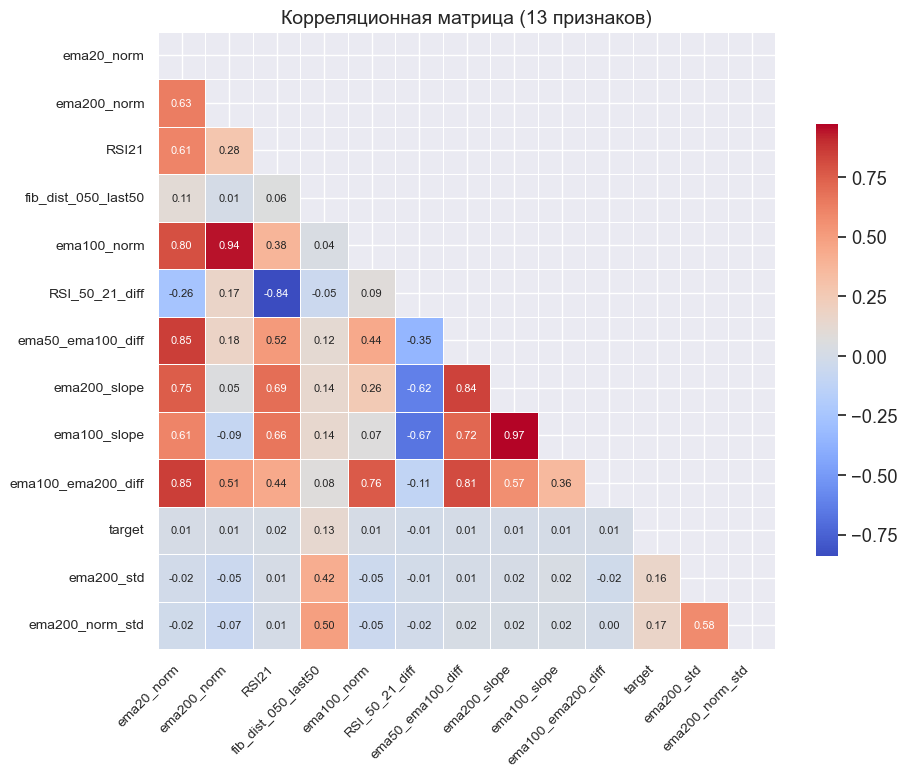

In [93]:
plot_correlation_matrix(df.drop(['Data', 'High', 'Low', 'Close', 'Open', 'Volume'],axis=1))

In [94]:
get_top_correlated_pairs(df.drop(['Data', 'High', 'Low', 'Close', 'Open', 'Volume'],axis=1,errors='ignore'),top_n=10)

Топ-10 пар по корреляции:
ema200_slope : ema100_slope : 0.9715
ema200_norm : ema100_norm : 0.9446
ema20_norm : ema50_ema100_diff : 0.8547
ema20_norm : ema100_ema200_diff : 0.8540
RSI21 : RSI_50_21_diff : 0.8416
ema50_ema100_diff : ema200_slope : 0.8405
ema50_ema100_diff : ema100_ema200_diff : 0.8087
ema20_norm : ema100_norm : 0.8006
ema100_norm : ema100_ema200_diff : 0.7619
ema20_norm : ema200_slope : 0.7543


# 📦 7. Feature Importance (до моделей)

**Цель**: понять, какие признаки наиболее важны\
**mutual_info_classif** вычисляет взаимную информацию между каждым признаком и целевой переменной.\
Оценивает нелинейные зависимости: Может выявить сложные связи, которые пропускает линейная корреляция

ℹ️ Calculating Mutual Information for 10 features...
✅ MI calculation completed in 149.75 seconds

🔍 Top 20 Features by Mutual Information:
| Feature             |   MI_Score |
|:--------------------|-----------:|
| fib_dist_050_last50 |     0.2342 |
| ema100_norm         |     0.0125 |
| ema200_norm         |     0.0124 |
| ema100_slope        |     0.0119 |
| ema200_slope        |     0.0118 |
| ema20_norm          |     0.0118 |
| ema50_ema100_diff   |     0.0107 |
| ema100_ema200_diff  |     0.0093 |
| RSI21               |     0.0088 |
| RSI_50_21_diff      |     0.0080 |


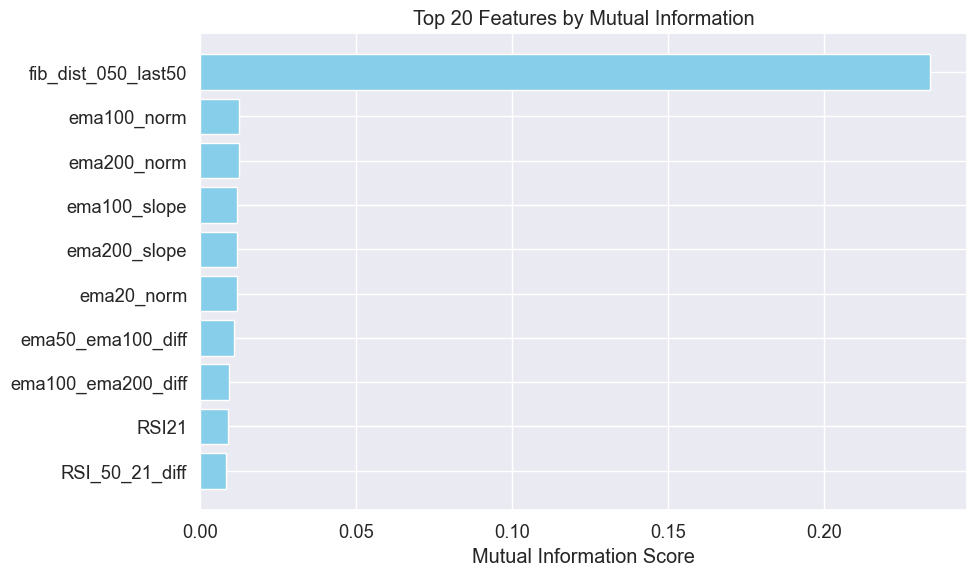

In [97]:
explain_model_mutual_info(X_train, y_train, top_n=20)

Точечный график распределения **целевой переменной**.\
Визуализация парных взаимосвязей между признаками и целевой переменной

In [99]:
df_cut = df.iloc[100000:110000]
plot_feature_pairplot(df_cut, ['ema100_norm', 'ema50_ema100_diff', 'vwap_price_distance', 'ema200_slope', 'RSI21', 'vwap_ema6h_zscore'])

Ошибка: в DataFrame отсутствует колонка "['vwap_price_distance', 'vwap_ema6h_zscore'] not in index"


# 🤖 8. Обучение моделей (LogReg, RandomForest)

## Логистическая регрессия - base line

In [102]:
start_time = time.time()

# Модели и метрики по каждому таргету

y_train_single = y_train
y_valid_single = y_valid

logreg = LogisticRegression(
        class_weight='balanced',
        random_state=3,
        max_iter=100,  
        n_jobs=-1,      
        solver='lbfgs'  
    )
logreg.fit(X_train, y_train_single)
y_pred = logreg.predict(X_valid)

f1 = f1_score(y_valid_single, y_pred)
precision = precision_score(y_valid_single, y_pred)
recall = recall_score(y_valid_single, y_pred)

print(f'✅ F1 score (target): {f1:.4f}')
print(f'✅ Precision (target): {precision:.4f}')
print(f'✅ Recall (target): {recall:.4f}')
# Сохраняем модель
trained_logreg = logreg    

print("⏱ Время выполнения: {:.2f} сек".format(time.time() - start_time))

✅ F1 score (target): 0.1859
✅ Precision (target): 0.1451
✅ Recall (target): 0.2586
⏱ Время выполнения: 5.31 сек


## Случайный лес - base line

In [104]:
start_time = time.time()

# Определение target_name (пример)
target_name = 'target'

# Модели и метрики по каждому таргету
y_train_single = y_train
y_valid_single = y_valid

# Более оптимальные параметры
forest_base_line = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    max_depth=7,
    min_samples_leaf=1,
    min_samples_split=6,
    max_features=0.8,
    max_samples=0.8,
    random_state=3,
    n_jobs=6
)

# Обучение с кросс-валидацией (опционально)
forest = forest_base_line.fit(X_train, y_train_single)

# Предсказание
y_pred = forest_base_line.predict(X_valid)

# Расчет метрик
f1 = f1_score(y_valid_single, y_pred)
precision = precision_score(y_valid_single, y_pred)
recall = recall_score(y_valid_single, y_pred)
    
print(f'✅ F1 score ({target_name}): {f1:.4f}')
print(f'✅ Precision ({target_name}): {precision:.4f}')
print(f'✅ Recall ({target_name}): {recall:.4f}')

print("⏱ Время выполнения: {:.2f} сек".format(time.time() - start_time))

✅ F1 score (target): 0.2451
✅ Precision (target): 0.1528
✅ Recall (target): 0.6195
⏱ Время выполнения: 207.61 сек


In [125]:
forest_base_line.feature_names_in_

array(['ema20_norm', 'ema200_norm', 'RSI21', 'fib_dist_050_last50',
       'ema100_norm', 'RSI_50_21_diff', 'ema50_ema100_diff',
       'ema200_slope', 'ema100_slope', 'ema100_ema200_diff'], dtype=object)

**Сохранения модели RandomForest Base line**

In [22]:
# Сохранение новой модели
save_model_with_threshold(
    model_name='forest_base_line',
    model=forest_base_line,
    params=forest_base_line.get_params,
    threshold=0.5, #logreg_package['metrics']['optimal_threshold'] - путь для функции evaluate_model_with_threshold
    features = list(X_train.columns)
)

✅ Модель сохранена в model_exports\forest_base_line_with_threshold.pkl (сжатие: уровень 3)


**Загрузка модели RandomForest**

In [16]:
import joblib
forest_base_line_package = load_model_with_threshold('forest_base_line')  # Обратите внимание на имя переменной
forest_base_line = forest_base_line_package['model']
forest_base_line_params = forest_base_line_package['params']
forest_base_line_threshold = forest_base_line_package['threshold']

✅ Модель 'forest_base_line' загружена из C:\Users\nikita\Documents\MagisterML\MyJupiter\trading_project\modules\..\model_exports\forest_base_line_with_threshold.pkl


# 🎯 9. Метрики: Precision, Recall, F1

Сравнение метрик **Random Forest** и **LogisticRegression**

In [127]:
y_proba_forest = forest_base_line.predict_proba(X_valid)[:, 1]       # Предсказанная вероятность
y_pred_forest = (y_proba_forest >= 0.5).astype(int)             # Базовый порог = 0.5
print('Метрики для модели Random Forest')
print("Precision:", precision_score(y_valid, y_pred_forest))
print("Recall:", recall_score(y_valid, y_pred_forest))
print("F1 Score:", f1_score(y_valid, y_pred_forest))
print()
y_proba_logreg = trained_logreg.predict_proba(X_valid)[:, 1]       # Предсказанная вероятность
y_pred_logreg = (y_proba_logreg >= 0.5).astype(int)             # Базовый порог = 0.5
print('Метрики для модели Log Reg')
print("Precision:", precision_score(y_valid, y_pred_logreg))
print("Recall:", recall_score(y_valid, y_pred_logreg))
print("F1 Score:", f1_score(y_valid, y_pred_logreg))

Метрики для модели Random Forest
Precision: 0.15280581764245396
Recall: 0.6194671788875897
F1 Score: 0.24514178068609954

Метрики для модели Log Reg
Precision: 0.145113292874382
Recall: 0.25860197093703025
F1 Score: 0.185906191369606


Построение **precision-recall** кривой для модели с наивысшим значением **f1**.\
Позволяет визуально выбрать лучший порог вероятности:

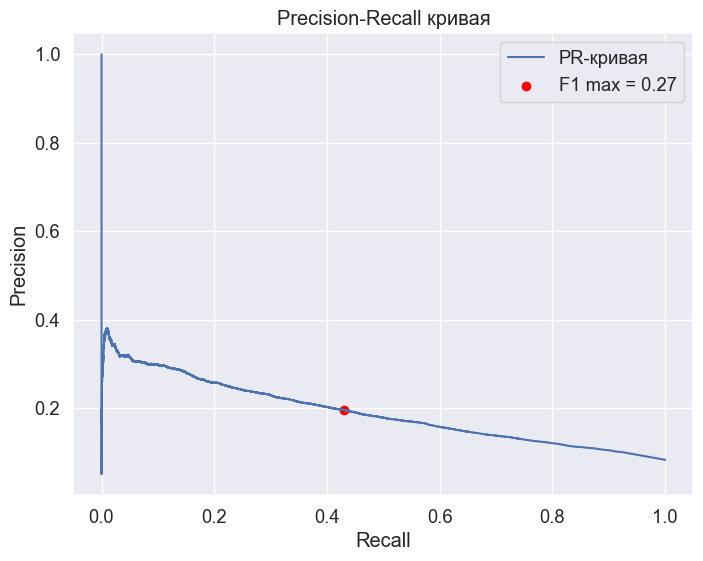

🔎 Лучший порог = 0.610, F1 = 0.269


In [130]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_proba_forest)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# Визуализация
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR-кривая")
plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"F1 max = {f1_scores[best_idx]:.2f}")
plt.title("Precision-Recall кривая")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

print(f"🔎 Лучший порог = {best_threshold:.3f}, F1 = {f1_scores[best_idx]:.3f}")

# ⚖️ 10. Анализ попрога вхождения для модели

Функция **evaluate_model_with_threshold** анализирует модель бинарной классификации, подбирая оптимальный порог вероятности для предсказаний.\
Сравнивает метрики (**F1, Precision, Recall, ROC-AUC**) на тренировочной, валидационной и тестовой выборках, визуализирует зависимость метрик от порога и возвращает итоговые результаты.

🎯 Лучший порог по F1 (Train): 0.6200
🎯 Лучший порог по F1 (Valid): 0.6100
✅ Усредненный оптимальный порог: 0.6150

📊 ROC AUC Scores:
✅ Train ROC AUC: 0.7118
✅ Valid ROC AUC: 0.7096

📊 Train set (Threshold = 0.6150):
✅ F1: 0.2737
✅ Precision: 0.2026
✅ Recall: 0.4215
✅ ROC AUC: 0.7118

📊 Valid set (Threshold = 0.6150):
✅ F1: 0.2683
✅ Precision: 0.1975
✅ Recall: 0.4183
✅ ROC AUC: 0.7096

📊 Test set (Threshold = 0.6150):
✅ F1: 0.2801
✅ Precision: 0.2092
✅ Recall: 0.4240
✅ ROC AUC: 0.6538


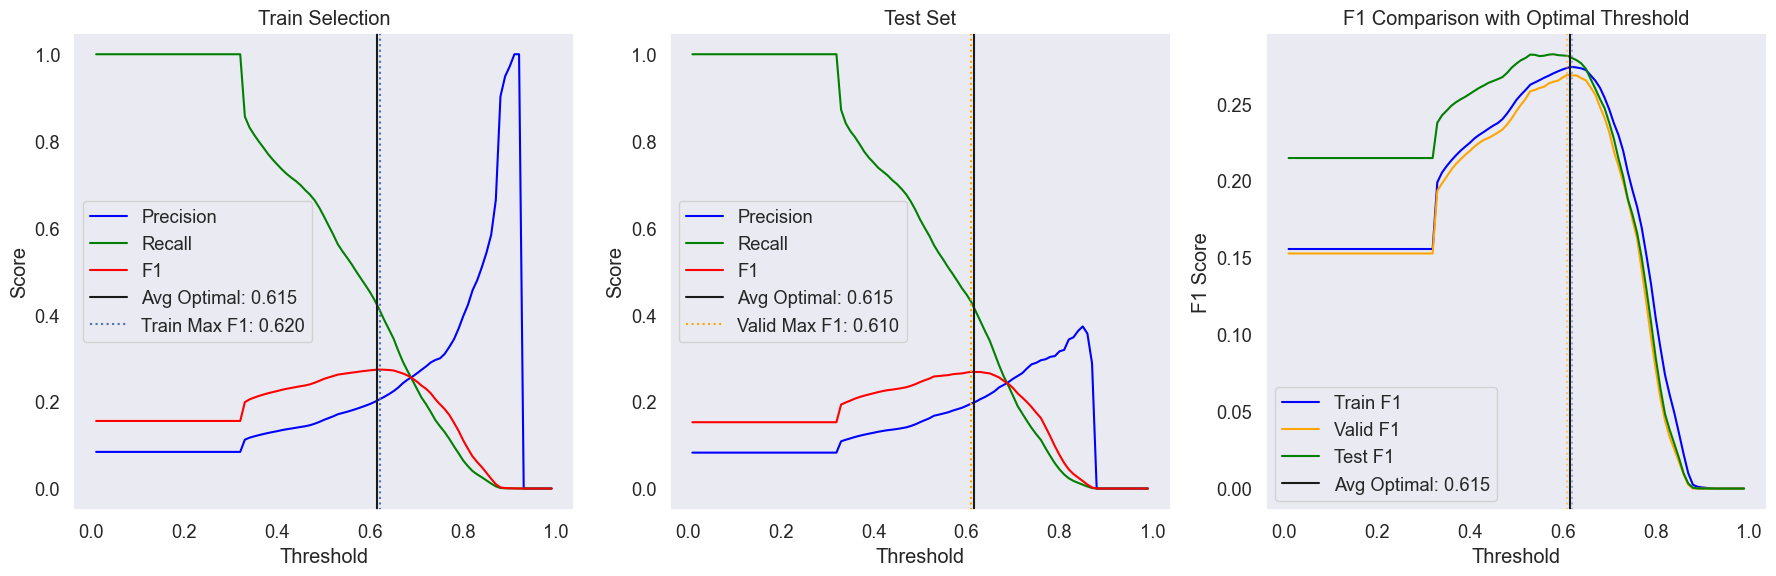


Итоговые метрики со средним оптимальным порогом:
+-----------+--------------------------+--------+-------------+----------+-----------+
| Dataset   | Threshold Type           |     F1 |   Precision |   Recall |   ROC_AUC |
+===========+==========================+========+=============+==========+===========+
| Train     | Average Optimal (0.6150) | 0.2737 |      0.2026 |   0.4215 |    0.7118 |
+-----------+--------------------------+--------+-------------+----------+-----------+
| Test      | Average Optimal (0.6150) | 0.2683 |      0.1975 |   0.4183 |    0.7096 |
+-----------+--------------------------+--------+-------------+----------+-----------+
| Test      | Average Optimal (0.6150) | 0.2801 |      0.2092 |   0.4240 |    0.6538 |
+-----------+--------------------------+--------+-------------+----------+-----------+


In [134]:
forest_base_line_package = evaluate_model_with_threshold(forest, X_train, y_train, X_valid, y_valid, X_test, y_test)

# 🧠 11. Интерпретация влияния признаков на модель 

## SHAP (SHapley Additive exPlanations)

**SHAP** - это метод объяснения предсказаний модели, основанный на теории игр (значения Шепли).\
Он показывает вклад каждого признака в конкретное предсказание, учитывая все возможные комбинации признаков.

ℹ️ Model type: RandomForestClassifier
ℹ️ Number of classes: 2
🔄 Initializing SHAP explainer...
✅ SHAP explainer initialized in 0:00:00.015966

🔄 Calculating SHAP values for 10000 samples...
✅ SHAP values calculated in 0:00:10.449474
⏱ Average time per sample: 0.0010 seconds
ℹ️ Processed SHAP values shape: (10000, 10)

🔄 Calculating feature importance...
✅ Feature analysis completed in 0:00:00.074158

🔍 Top Features by SHAP Importance:
|   Rank | Feature             |   SHAP_% | Direction   |   Model_% |
|-------:|:--------------------|---------:|:------------|----------:|
|      1 | ema200_norm         |    100.0 | Negative    |      97.9 |
|      2 | ema100_slope        |     75.9 | Negative    |      75.8 |
|      3 | fib_dist_050_last50 |     66.2 | Negative    |     100.0 |
|      4 | ema20_norm          |     52.3 | Negative    |      47.9 |
|      5 | ema50_ema100_diff   |     35.8 | Negative    |      26.4 |
|      6 | ema100_norm         |     33.4 | Negative    |      30.8 |
|

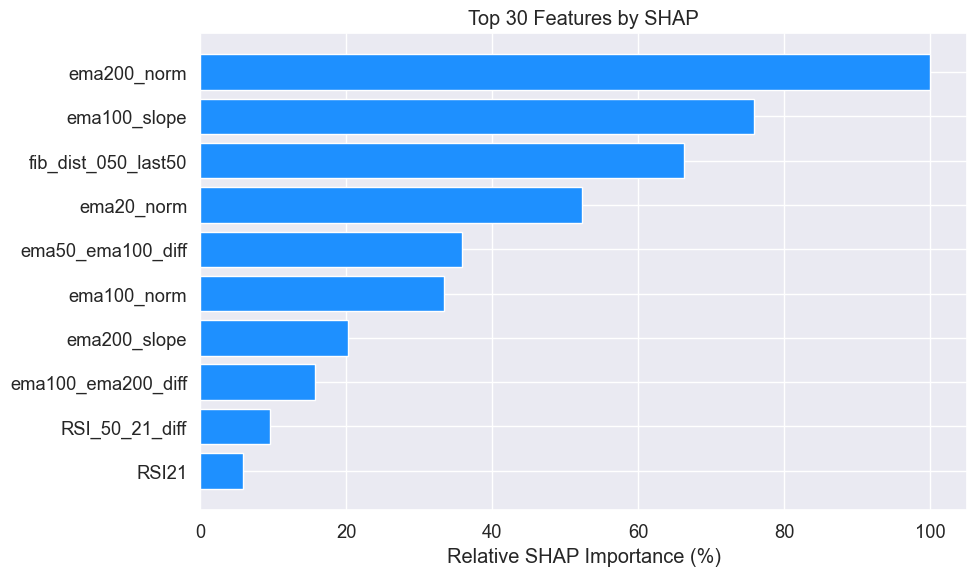


⏱ Total execution time: 0:00:10.995403
Time breakdown:
- Explainer init: 0:00:00.015966
- SHAP values: 0:00:10.449474 (95.0%)
- Analysis: 0:00:00.074158 (0.7%)


In [138]:
# Пример использования:
# explain_model_shap(X_train, logreg_model)
explain_model_shap(X_train, forest_base_line, sample_size=10000, top_n=30);

## Permutation Importance (Перестановочная важность)

**Permutation Importance** – это метод оценки важности признаков, основанный на ухудшении качества модели при случайном перемешивании значений признака.\
Если после перемешивания метрика модели значительно падает, признак считается важным.

ℹ️ Model type: RandomForestClassifier
ℹ️ Scoring metric: f1
🔄 Calculating permutation importance...
✅ Completed in 0:00:39.302812

🔍 Top Features by Permutation Importance:
|   Rank | Feature             |   Mean Importance |   Std | Significant   |
|-------:|:--------------------|------------------:|------:|:--------------|
|      1 | ema100_slope        |             0.040 | 0.000 | True          |
|      2 | ema200_norm         |             0.036 | 0.000 | True          |
|      3 | fib_dist_050_last50 |             0.011 | 0.000 | True          |
|      4 | ema50_ema100_diff   |             0.008 | 0.000 | True          |
|      5 | RSI21               |             0.005 | 0.000 | True          |
|      6 | ema100_ema200_diff  |             0.004 | 0.000 | True          |
|      7 | RSI_50_21_diff      |             0.004 | 0.000 | True          |
|      8 | ema20_norm          |             0.002 | 0.000 | True          |
|      9 | ema200_slope        |             0.001 | 0.00

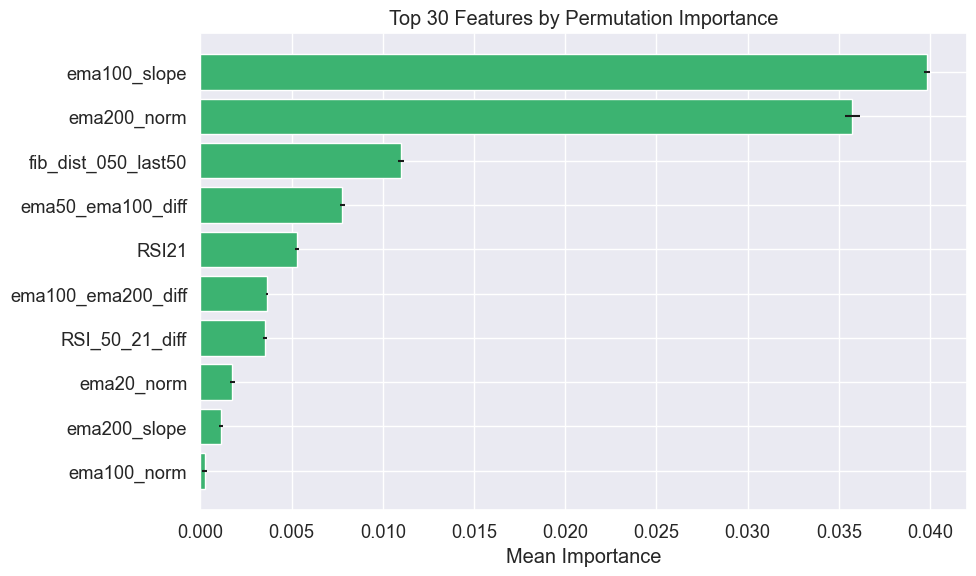

In [141]:
permutation_result = explain_model_permutation(X_train, y_train, forest, scoring='f1', top_n=30);

ℹ️ Model type: RandomForestClassifier
ℹ️ Scoring metric: precision
🔄 Calculating permutation importance...
✅ Completed in 0:00:35.770255

🔍 Top Features by Permutation Importance:
|   Rank | Feature             |   Mean Importance |   Std | Significant   |
|-------:|:--------------------|------------------:|------:|:--------------|
|      1 | ema100_slope        |             0.030 | 0.000 | True          |
|      2 | ema200_norm         |             0.025 | 0.000 | True          |
|      3 | fib_dist_050_last50 |             0.009 | 0.000 | True          |
|      4 | ema50_ema100_diff   |             0.006 | 0.000 | True          |
|      5 | RSI21               |             0.005 | 0.000 | True          |
|      6 | ema100_ema200_diff  |             0.003 | 0.000 | True          |
|      7 | RSI_50_21_diff      |             0.003 | 0.000 | True          |
|      8 | ema20_norm          |             0.001 | 0.000 | True          |
|      9 | ema200_slope        |             0.001

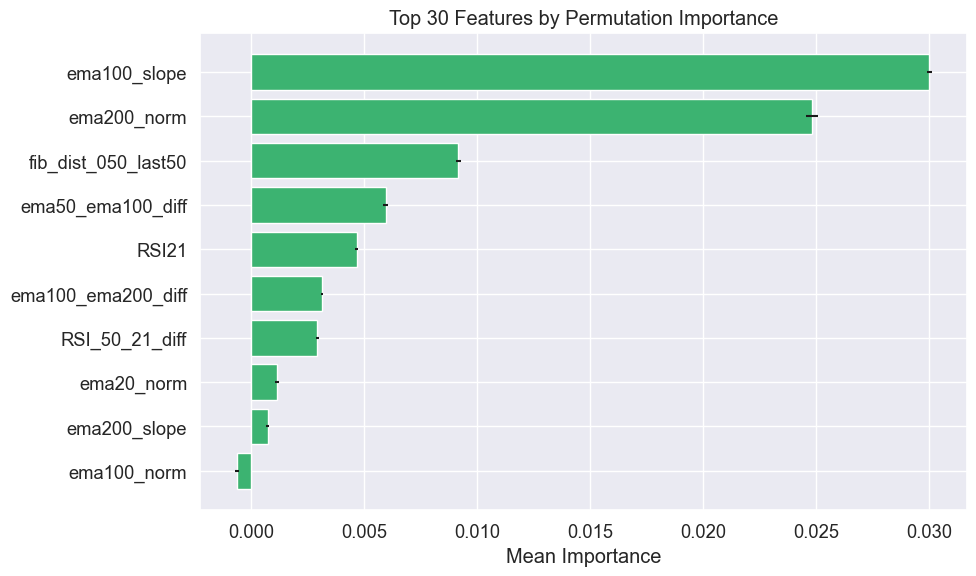

In [142]:
permutation_result = explain_model_permutation(X_train, y_train, forest, scoring='precision', top_n=30);

## RFECV (Recursive Feature Elimination with Cross-Validation) + TimeSeriesSplit

**RFECV** – это метод автоматического выбора оптимального набора признаков для модели машинного обучения, сочетающий рекурсивное исключение признаков (RFE) и кросс-валидацию TimeSeriesSplit (TSCV).

Fitting estimator with 10 features.

✅ Признаки, отобранные RFECV:
['ema20_norm', 'ema200_norm', 'RSI21', 'fib_dist_050_last50', 'ema100_norm', 'RSI_50_21_diff', 'ema50_ema100_diff', 'ema100_slope', 'ema100_ema200_diff']


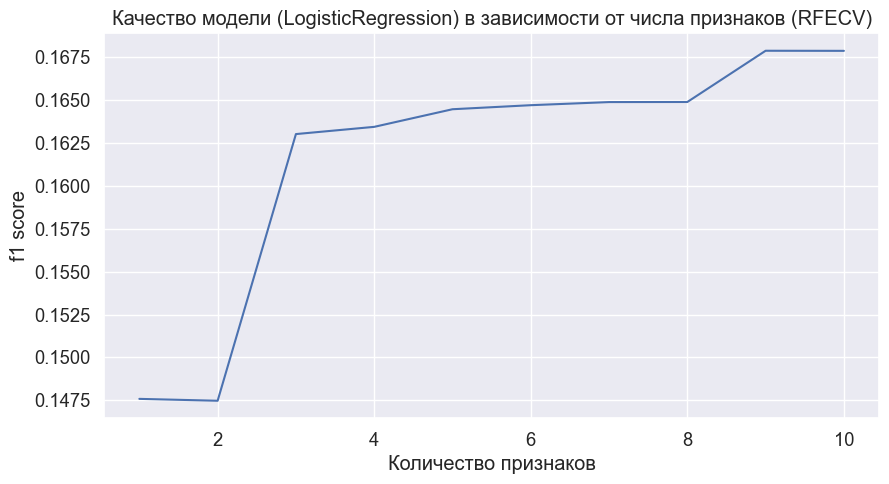

In [147]:
show_rfecv_results(X_train, y_train, logreg, 
                      scoring='f1', step=1, n_splits=2, 
                      n_jobs=6, verbose=1);

## Boruta

**Boruta** – это алгоритм выбора признаков, основанный на идее "тени признаков" (shadow features) и статистических тестах. Он сравнивает важность исходных признаков с важностью искусственно созданных случайных признаков, чтобы определить, какие из исходных фичей действительно значимы.

In [ ]:
explain_model_boruta(X_train, X_valid, y_train, y_valid, forest, max_iter=50, perc=50, n_splits=2)

ℹ️ Model type: RandomForestClassifier
ℹ️ Boruta params: max_iter=50, perc=50, alpha=0.05
ℹ️ TimeSeriesSplit n_splits: 2
🔄 Running Boruta feature selection on time series splits...
  • Fold 1/2 — Train size: 386252, Test size: 386250


# Участки где модель дает сигнал

In [149]:
# Преобразуем строку с датой в datetime, если еще не сделано
df_test['Data'] = pd.to_datetime(df_test['Data'])

# Укажем нужный временной интервал
start_date = '2025-07-09 17:00:00'
end_date = '2025-07-10 00:00:00'

# Фильтруем по диапазону дат
df_last_2000 = df_test[(df_test['Data'] >= start_date) & (df_test['Data'] <= end_date)].copy()

# Выделим X_test — только фичи, которые использует модель
features_columns = forest_base_line.feature_names_in_
X_test_last_2000 = df_last_2000[features_columns]

# Получаем вероятности класса 1
probabilities = forest_base_line.predict_proba(X_test_last_2000)
df_last_2000['Probability_1'] = probabilities[:, 1]

FloatSlider(value=0.6, continuous_update=False, description='Порог:', max=1.0, step=0.01)

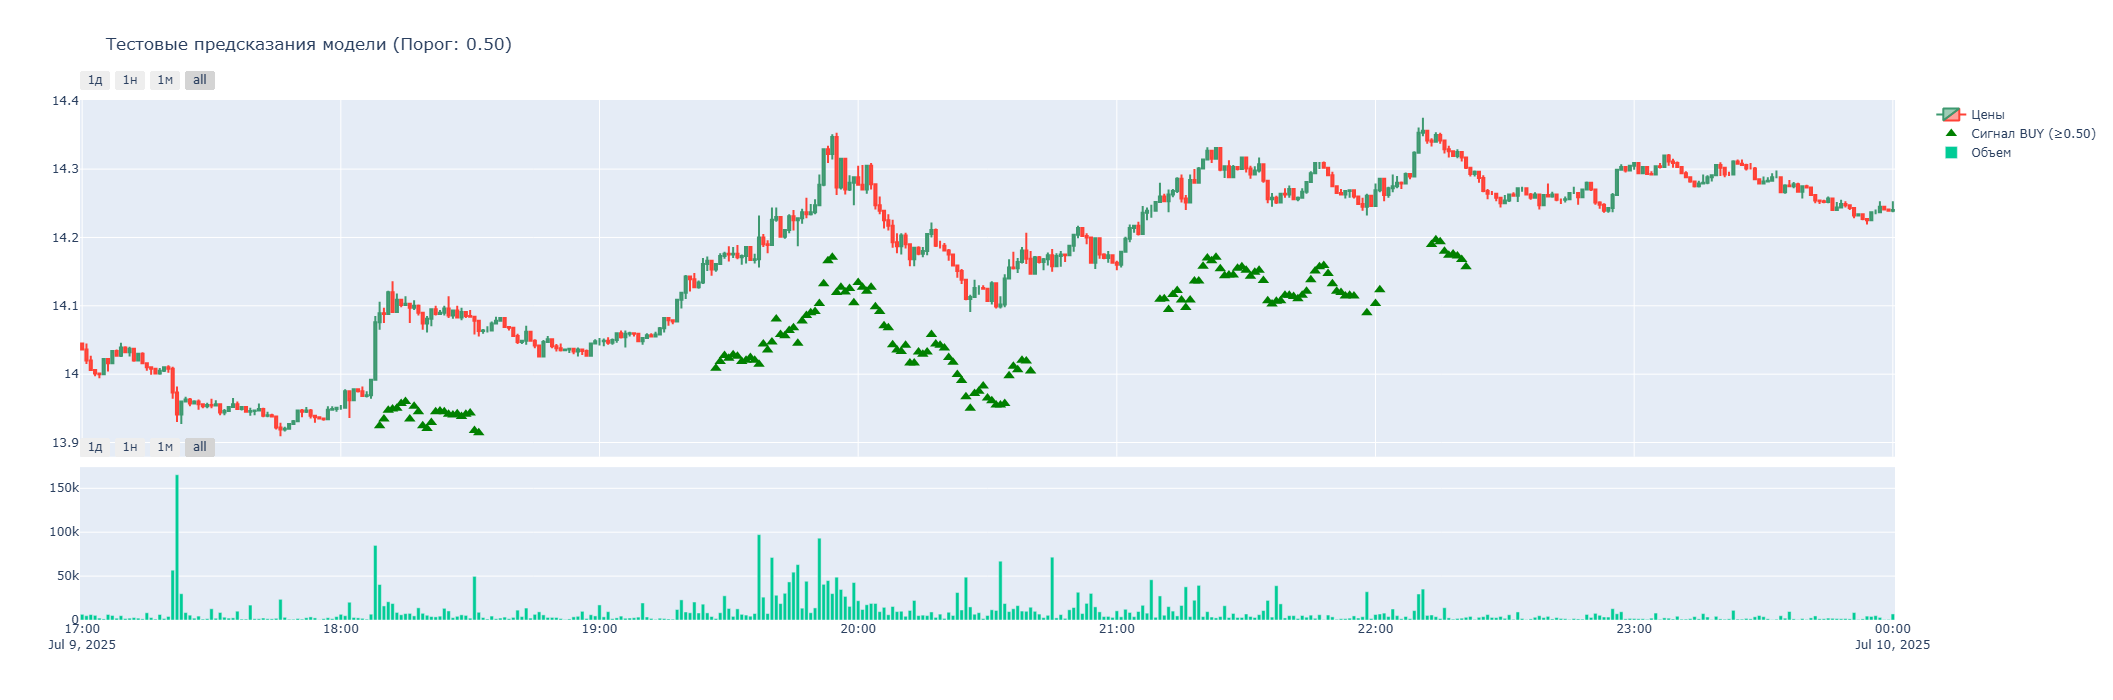

In [151]:
# Функция для обновления графика при изменении порога
def update_plot(threshold):
    # Создаем сигналы на основе порога
    df_last_2000['Signal'] = (df_last_2000['Probability_1'] >= threshold).astype(int)
    
    # Создаем новый график
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                       vertical_spacing=0.02,
                       row_heights=[0.7, 0.3])

    # Свечной график
    fig.add_trace(go.Candlestick(
        x=df_last_2000['Data'],
        open=df_last_2000['Open'],
        high=df_last_2000['High'],
        low=df_last_2000['Low'],
        close=df_last_2000['Close'],
        name='Цены'
    ), row=1, col=1)

    # Сигналы модели (где вероятность >= порогу)
    signals = df_last_2000[df_last_2000['Signal'] == 1]
    fig.add_trace(go.Scatter(
        x=signals['Data'],
        y=signals['Low'] * 0.99,  # маркеры чуть ниже минимумов
        mode='markers',
        marker=dict(color='green', size=10, symbol='triangle-up'),
        name=f'Сигнал BUY (≥{threshold:.2f})'
    ), row=1, col=1)

    # Объемы торгов
    fig.add_trace(go.Bar(
        x=df_last_2000['Data'],
        y=df_last_2000['Volume'],
        name='Объем'
    ), row=2, col=1)

    # Настройки графика
    fig.update_layout(
        title=f'Тестовые предсказания модели (Порог: {threshold:.2f})',
        xaxis_rangeslider_visible=False,
        hovermode='x unified',
        height=700
    )

    # Добавляем кнопки для навигации по времени
    fig.update_xaxes(
        rangebreaks=[{'bounds': ['sat', 'mon']}],  # скрываем выходные
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1д", step="day", stepmode="backward"),
                dict(count=7, label="1н", step="day", stepmode="backward"),
                dict(count=1, label="1м", step="month", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    
    fig.show()

# Создаем слайдер для порога
threshold_slider = widgets.FloatSlider(
    value=0.6,
    min=0.0,
    max=1.0,
    step=0.01,
    description='Порог:',
    continuous_update=False
)

# Связываем слайдер с функцией обновления
widgets.interactive(update_plot, threshold=threshold_slider)

# Отображаем слайдер и начальный график
display(threshold_slider)
update_plot(0.5)

# Поиск оптимальной цели

In [64]:
from tqdm import tqdm
import pandas as pd

def run_target_search(df,
                      target_candles_list=[3, 5, 7, 10, 15, 20],
                      target_list=[0.015, 0.02, 0.025, 0.03, 0.04],
                      rr_threshold=2.0,
                      model_params=None,
                      test_size=0.2):

    # Параметры модели по умолчанию
    default_model_params = {
        'class_weight': 'balanced',
        'n_estimators': 100,
        'max_depth': 8,
        'min_samples_leaf': 3,
        'min_samples_split': 2,
        'max_features': 0.8,
        'max_samples': 0.8,
        'random_state': 3,
        'n_jobs': 6
    }
    
    if model_params is not None:
        default_model_params.update(model_params)
    
    results = []
    total_combinations = len(target_candles_list) * len(target_list)
    
    # Создаем progress bar для всех комбинаций
    with tqdm(total=total_combinations, desc="Processing combinations") as pbar:
        for tc in target_candles_list:
            for tgt in target_list:
                try:
                    df_local = df.copy()

                    # Обновляем целевую переменную
                    df_local = df_local.drop(columns=['target'], errors='ignore')
                    df_local = add_target_column_mod(
                        df_local, 
                        target_candles=tc, 
                        target=tgt, 
                        rr_threshold=rr_threshold
                    )

                    # Удаляем строки с NaN в target
                    df_local = df_local.dropna(subset=['target'])

                    # Разделяем на признаки и целевую переменную
                    X = df_local.drop(['target', 'Data', 'High', 'Low', 'Close', 'Open', 'Volume'], axis=1)
                    y = df_local['target']

                    # Разделяем на train/valid
                    separate = int(len(X) * (1 - test_size))
                    X_train, X_valid = X.iloc[:separate], X.iloc[separate:]
                    y_train, y_valid = y.iloc[:separate], y.iloc[separate:]

                    # Инициализируем и обучаем модель
                    model = RandomForestClassifier(**default_model_params)
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_valid)

                    # Считаем метрики
                    f1 = f1_score(y_valid, y_pred)
                    precision = precision_score(y_valid, y_pred)
                    recall = recall_score(y_valid, y_pred)
                    positive_ratio = y_train.mean()

                    results.append({
                        'target_candles': tc,
                        'target': tgt,
                        'rr_threshold': rr_threshold,
                        'f1': f1,
                        'precision': precision,
                        'recall': recall,
                        'positive_ratio': positive_ratio,
                        'train_samples': len(y_train),
                        'valid_samples': len(y_valid),
                        'features_used': X.shape[1]
                    })
                    
                except Exception as e:
                    print(f"Error with tc={tc}, tgt={tgt}: {str(e)}")
                    results.append({
                        'target_candles': tc,
                        'target': tgt,
                        'rr_threshold': rr_threshold,
                        'f1': None,
                        'precision': None,
                        'recall': None,
                        'positive_ratio': None,
                        'train_samples': None,
                        'valid_samples': None,
                        'features_used': None,
                        'error': str(e)
                    })
                
                pbar.update(1)
    
    return pd.DataFrame(results)

In [69]:
# С пользовательскими параметрами модели
custom_params = {
    'n_estimators': 100,
    'max_depth': 8,
    'n_jobs': 6
}
results_df = run_target_search(
    df=df,
    target_candles_list=[10, 20, 30, 50],
    target_list=np.arange(0.004,0.021,0.002),
    rr_threshold=1.5,
    model_params=None,
    test_size=0.2
)


Processing combinations: 100%|██████████████████████████████████████████████████████| 36/36 [1:50:48<00:00, 184.67s/it]


In [70]:
results_df.sort_values('f1', ascending=False)

target_candles  target  rr_threshold        f1  precision    recall  \
27              50   0.004           1.5  0.512158   0.378129  0.793371   
18              30   0.004           1.5  0.482338   0.356948  0.743527   
9               20   0.004           1.5  0.457284   0.333150  0.728863   
28              50   0.006           1.5  0.454141   0.328648  0.734674   
19              30   0.006           1.5  0.419655   0.292692  0.741151   
29              50   0.008           1.5  0.402720   0.276707  0.739480   
0               10   0.004           1.5  0.398860   0.271247  0.753225   
10              20   0.006           1.5  0.382221   0.256750  0.747528   
20              30   0.008           1.5  0.355269   0.232103  0.756949   
30              50   0.010           1.5  0.355194   0.232857  0.748375   
11              20   0.008           1.5  0.314058   0.198038  0.758308   
31              50   0.012           1.5  0.309401   0.194790  0.751677   
21              30   0.010           1.5  0.305349   0.191934  0.746402   
1               10   0.006           1.5  0.299841   0.185042  0.789880   
32              50   0.014           1.5  0.277013   0.171824  0.714305   
22              30   0.012           1.5  0.254698   0.154160  0.732245   
12              20   0.010           1.5  0.246427   0.147340  0.752448   
33              50   0.016           1.5  0.245801   0.148443  0.714243   
2               10   0.008           1.5  0.209240   0.120743  0.783490   
34              50   0.018           1.5  0.207323   0.121399  0.709480   
23              30   0.014           1.5  0.203979   0.118882  0.717763   
13              20   0.012           1.5  0.187392   0.107641  0.723231   
35              50   0.020           1.5  0.174260   0.099863  0.683345   
24              30   0.016           1.5  0.162575   0.092003  0.697922   
3               10   0.010           1.5  0.148695   0.082304  0.769080   
14              20   0.014           1.5  0.143674   0.079957  0.707349   
25              30   0.018           1.5  0.135022   0.075062  0.671151   
15              20   0.016           1.5  0.115916   0.063216  0.696805   
4               10   0.012           1.5  0.109147   0.059058  0.718750   
26              30   0.020           1.5  0.108798   0.059376  0.648993   
16              20   0.018           1.5  0.095367   0.051291  0.677971   
5               10   0.014           1.5  0.083367   0.044358  0.691225   
17              20   0.020           1.5  0.076217   0.040521  0.640119   
6               10   0.016           1.5  0.065598   0.034559  0.644099   
7               10   0.018           1.5  0.052107   0.027162  0.638319   
8               10   0.020           1.5  0.045517   0.023628  0.618705   

    positive_ratio  train_samples  valid_samples  features_used  
27        0.346217        1158752         289688              7  
18        0.297606        1158752         289688              7  
9         0.248743        1158752         289688              7  
28        0.266833        1158752         289688              7  
19        0.201305        1158752         289688              7  
29        0.195252        1158752         289688              7  
0         0.159647        1158752         289688              7  
10        0.150263        1158752         289688              7  
20        0.132729        1158752         289688              7  
30        0.142689        1158752         289688              7  
11        0.091160        1158752         289688              7  
31        0.104460        1158752         289688              7  
21        0.089223        1158752         289688              7  
1         0.079747        1158752         289688              7  
32        0.077559        1158752         289688              7  
22        0.061424        1158752         289688              7  
12        0.057673        1158752         289688              7  
33        0.058406        1158752       

# 🔎 12. Выводы

?

## 📋 Выбор оптимальных признаков:

In [ ]:
🔍 Top Features by Permutation Importance:
|   Rank | Feature                    |   Mean Importance |   Std | Significant   |
|-------:|:---------------------------|------------------:|------:|:--------------|
|      1 | ema20_norm                 |             0.049 | 0.000 | True          |
|      2 | ema200_norm                |             0.030 | 0.000 | True          |
|      3 | RSI21                      |             0.014 | 0.000 | True          |
|      4 | fib_dist_050_last50        |             0.010 | 0.000 | True          |
|      5 | vwap_price_distance        |             0.006 | 0.000 | True          |
|      6 | ema100_norm                |             0.006 | 0.000 | True          |
|      7 | RSI_50_21_diff             |             0.004 | 0.000 | True          |
|      8 | vwap_ema6h_norm            |             0.003 | 0.000 | True          |
|      9 | vwap_price_distance_direct |             0.002 | 0.000 | True          |
|     10 | ema50_ema100_diff          |             0.002 | 0.000 | True          |
|     11 | ema200_slope               |             0.001 | 0.000 | True          |
|     12 | ema100_slope               |             0.001 | 0.000 | True          |
|     13 | ema100_ema200_diff         |             0.001 | 0.000 | True          |
|     14 | vwap_ema6h_zscore          |             0.001 | 0.000 | True          |

In [10]:
base_features = ['ema20_norm', 
                 'ema200_norm',
                'RSI21',
                'fib_dist_050_last50',
                'vwap_price_distance',
                 'ema100_norm',
                 'RSI_50_21_diff',
                 'vwap_ema6h_norm',
                 'vwap_price_distance_direct',
                 'ema50_ema100_diff',
                 'ema200_slope',
                 'ema100_slope',
                 'ema100_ema200_diff',
                 'vwap_ema6h_zscore',
                'Data', 'High', 'Low', 'Close', 'Open', 'Volume','target']

In [ ]:
ДЛЯ Таргета с условием
🔍 Top Features by Permutation Importance:
|   Rank | Feature                    |   Mean Importance |   Std | Significant   |
|-------:|:---------------------------|------------------:|------:|:--------------|
|      1 | RSI_50_21_diff             |             0.019 | 0.000 | True          |
|      2 | vwap_price_distance        |             0.012 | 0.001 | True          |
|      3 | atr_24_norm_velocity       |             0.011 | 0.000 | True          |
|      4 | obv_zscore                 |             0.005 | 0.000 | True          |
|      5 | volume_ma_ratio            |             0.004 | 0.000 | True          |
|      6 | ema20_norm                 |             0.003 | 0.000 | True          |
|      7 | ema100_norm                |             0.002 | 0.001 | True          |
|      8 | RSI21                      |             0.002 | 0.000 | True          |
|      9 | ema100_ema200_diff         |             0.001 | 0.000 | True          |
|     10 | vwap_ema6h_norm            |             0.001 | 0.000 | True          |
|     11 | force_index_z              |             0.001 | 0.000 | True          |

In [92]:
base_features = ['RSI_50_21_diff', 
                 'vwap_price_distance',
                'atr_24_norm_velocity',
                'obv_zscore',
                'volume_ma_ratio',
                 'ema20_norm',
                 'ema100_norm',
                 'RSI21',
                 'ema100_ema200_diff',
                 'vwap_ema6h_norm',
                 'force_index_z',
                'Data', 'High', 'Low', 'Close', 'Open', 'Volume','target']